
**Install requirements**

In [0]:
#!pip3 install 'torch==1.3.1'
#!pip3 install 'torchvision==0.5.0'
#!pip3 install 'Pillow-SIMD'
#!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import resnet18
from torchvision.models import vgg11

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # BACKGROUND_Google class removed

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results
# BATCH_SIZE = 64      # Smaller batch if using more advanced models than AlexNet

# LR = 1e-3          # The initial Learning Rate
LR = 5e-3

MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  #, 5e-3  # Regularization

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE =  6      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

# LOG_FREQUENCY = 10                    # Deprecated in my code
EVAL_MODEL_AFTER_EACH_EPOCH = True      # Computer loss and accuracy on val at each epoch
EVAL_ACCURACY_ON_TRAINING = True        # Compute accuracy on training at each epoch
COMPUTE_AVG_OUTCOME_PROBABILITY = False # Whether to compute average probability (softmax) of the correct class on the minibatch

PRETRAINED_ALEXNET = True
FREEZE_LAYERS = 1                       # 0: Don't freeze, 1: freeze conv. layers, 2: freeze FC layers

**Custom functions**

In [0]:
def imgshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    return

**Define Data Preprocessing**

In [0]:
if PRETRAINED_ALEXNET:
  normalization = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
else:
  normalization = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

# --- Data augmentation possible transformations: (they are applied at runtime on the minibatch, so it is like augmenting the data!)
# transforms.RandomCrop(224)
# transforms.RandomHorizontalFlip(p=0.5)
# transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0)

# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224), # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      #transforms.RandomCrop(224),
                                      #transforms.RandomHorizontalFlip(p=0.5),
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      normalization # Normalizes tensor with mean and standard deviation
])
val_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                    transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                    transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                    normalization # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalization                                    
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
import os
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

In [7]:
DATA_DIR = 'Caltech101/101_ObjectCategories/' # Dir path with slash at the end
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform, debug=False)
val_dataset = Caltech(DATA_DIR, split='train',  transform=val_transform, debug=False)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform, debug=False)

# Get info on classes
classes = train_dataset.classes.copy() # ['Faces', etc.]
classesDict = train_dataset.classesDict # {'Faces': 0, 'Faces_easy': 1, etc.}

# Split train into train and val
train_indexes, val_indexes, y_train, y_val = train_test_split([i for i in range(len(train_dataset))], [item[1] for item in train_dataset.validIndexes], test_size=0.5, stratify=[item[1] for item in train_dataset.validIndexes])

#val_dataset = Subset(train_dataset, val_indexes)
val_dataset = Subset(val_dataset, val_indexes) # Like this I can apply torchvision tranformations on the training set only
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

--- LOADING train DATASET ---
Ignored file: "BACKGROUND_Google/tmp" in: train
---
--- LOADING train DATASET ---
Ignored file: "BACKGROUND_Google/tmp" in: train
---
--- LOADING test DATASET ---
---
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [9]:
if PRETRAINED_ALEXNET == False:
  net = alexnet(pretrained=False) # Loading AlexNet model
else:
  net = alexnet(pretrained=True)

# --- EXTRA
#net = resnet18(pretrained=True)
#net.fc = nn.Linear(512, NUM_CLASSES)
#net = vgg11(pretrained=True)
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
criterion_val = nn.CrossEntropyLoss(reduction='sum') # for evaluation I don't want to avg over every minibatch

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
if FREEZE_LAYERS == 0:
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif FREEZE_LAYERS == 1: # Freeze Conv. layers
  parameters_to_optimize = net.classifier.parameters() # Only update FC layers parameters
elif FREEZE_LAYERS == 2: # Freeze FC layers
  parameters_to_optimize = net.features.parameters() # Only update conv. layers parameters
else:
  print('Errore fatale nel settaggio dei FREEZE_LAYERS')
  sys.exit()

# Define optimizer for gradient descent
# An optimizer updates the weights based on their gradient on the loss
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# Adam requires a smaller LR otherwise it tends to diverge at the very first iterations (Use LR <= 1e-3)
#optimizer = optim.Adam(parameters_to_optimize, lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY, amsgrad=False)
#optimzer = optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
losses_train = []
losses_val = []
accuracies_val = []
accuracies_train = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)
    
    # print(outputs) # Initially, they are very close to zero e.g. [3.7863e-03, -1.7505e-02, -4.1586e-03,  ...,  1.3966e-02,
                     # -9.5620e-03,  1.3556e-03]

    # print(outputs.detach().cpu().numpy().var(axis=-1)) # Really small variance at the beginning

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    if current_step == 0:
      print('--- Initial loss on train: {}'.format(loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients    

    current_step += 1

  # End of one epoch    
  print('--- Epoch {}, Loss on train: {}'.format(epoch+1, loss.item()))
  losses_train.append(loss.item())

  if COMPUTE_AVG_OUTCOME_PROBABILITY:
    softmaxs = F.softmax(outputs, dim=-1)
    softmaxs = softmaxs.detach().cpu().numpy()
    prob_for_each_sample = np.array([softmaxs[i, labels[i]] for i in range(len(softmaxs))])

    mean_true_prob = prob_for_each_sample.mean()
    mean_lower_bound = np.exp(-1*loss.item())

    print('(TRUE,LB):', mean_true_prob, mean_lower_bound) # All'inizio i valori sono comunque molto bassi e in un intorno abbastanza piccolo di 0.0099 si può considerare lineare log(x)

  if EVAL_MODEL_AFTER_EACH_EPOCH:
    # EVALUATE TEMPORARY MODEL ON VALIDATION SET
    net.train(False)

    running_corrects_val = 0
    cum_loss_val = 0

    #for images_val, labels_val in tqdm(val_dataloader):
    for images_val, labels_val in val_dataloader:
      images_val = images_val.to(DEVICE)
      labels_val = labels_val.to(DEVICE)

      # Forward Pass
      outputs_val = net(images_val)

      cum_loss_val += criterion_val(outputs_val, labels_val).item()

      # Get predictions
      _, preds = torch.max(outputs_val.data, 1)

      # Update Corrects
      running_corrects_val += torch.sum(preds == labels_val.data).data.item()

    # Calculate Accuracy
    accuracy_val = running_corrects_val / float(len(val_dataset))
    loss_val = cum_loss_val / float(len(val_dataset))

    losses_val.append(loss_val)
    accuracies_val.append(accuracy_val)
    
    print('Loss on val:', loss_val)
    print('Accuracy on val:', accuracy_val)

  if EVAL_ACCURACY_ON_TRAINING:
    net.train(False)

    running_corrects_train = 0

    for images_train, labels_train in train_dataloader:
      images_train = images_train.to(DEVICE)
      labels_train = labels_train.to(DEVICE)

      # Forward Pass
      outputs_train = net(images_train)

      # Get predictions
      _, preds = torch.max(outputs_train.data, 1)

      # Update Corrects
      running_corrects_train += torch.sum(preds == labels_train.data).data.item()

    # Calculate Accuracy
    accuracy_train = running_corrects_train / float(len(train_dataset))

    accuracies_train.append(accuracy_train)

    print('Accuracy on train:', accuracy_train)
  # Step the scheduler
  scheduler.step() 

Starting epoch 1/10, LR = [0.005]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


--- Initial loss on train: 4.967557430267334
--- Epoch 1, Loss on train: 2.281343936920166
Loss on val: 1.990236073938478
Accuracy on val: 0.5477178423236515
Accuracy on train: 0.5674273858921162
Starting epoch 2/10, LR = [0.005]
--- Epoch 2, Loss on train: 0.9561805129051208
Loss on val: 1.0854530941236398
Accuracy on val: 0.7468879668049793
Accuracy on train: 0.8208852005532503
Starting epoch 3/10, LR = [0.005]
--- Epoch 3, Loss on train: 0.5013899207115173
Loss on val: 0.7557550538460084
Accuracy on val: 0.8063623789764869
Accuracy on train: 0.9118257261410788
Starting epoch 4/10, LR = [0.005]
--- Epoch 4, Loss on train: 0.2333037406206131
Loss on val: 0.6609707010567271
Accuracy on val: 0.8236514522821576
Accuracy on train: 0.9415629322268326
Starting epoch 5/10, LR = [0.005]
--- Epoch 5, Loss on train: 0.18243564665317535
Loss on val: 0.6236945016420399
Accuracy on val: 0.8278008298755186
Accuracy on train: 0.9564315352697096
Starting epoch 6/10, LR = [0.005]
--- Epoch 6, Loss on 

In [0]:
#initialNet = alexnet(pretrained=True)

# --- Check if FC layers parameters changed from the beginning
#print(list(net.classifier.parameters())[0][0].data.cpu().numpy() == list(initialNet.classifier.parameters())[0][0].data.cpu().numpy())

# --- Check if Conv. layers parameters changed from the beginning
#print(list(net.features.parameters())[0][0][0].data.cpu().numpy() == list(initialNet.features.parameters())[0][0][0].data.cpu().numpy())

**Plot results after training**

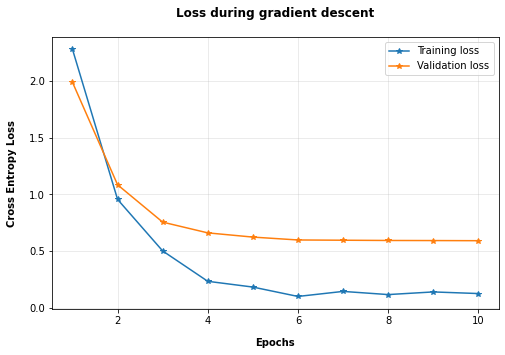

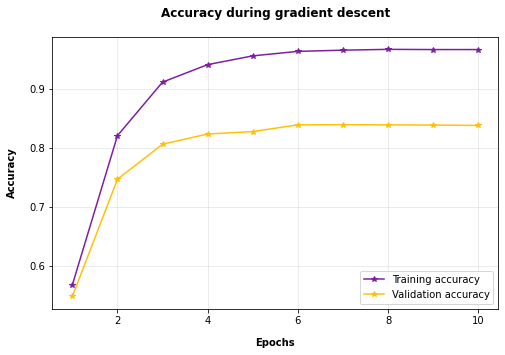

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax.plot(epochs, losses_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, losses_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot accuracies

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax.plot(epochs, accuracies_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, accuracies_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

**Validation**

In [14]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

Validation Accuracy: 0.8381742738589212


**Test**

In [15]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:10<00:00,  1.14it/s]

Test Accuracy: 0.8347735914275838
